# Importation Station

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.svm import LinearSVC, SVC
from imblearn.under_sampling import RandomUnderSampler

plt.style.use("seaborn")
%matplotlib inline

%load_ext autotime

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Make DataFrame and Extract Features

## Read Initial Data

In [2]:
# df= pd.read_csv("us-perm-visas.zip")
# df.head()

time: 2.76 ms


## Extract Features of Interest

In [3]:
# df_feat=df[['class_of_admission','country_of_citizenship',
#             'country_of_citzenship','case_status', 'employer_state','foreign_worker_info_city',
#             'foreign_worker_info_education','foreign_worker_info_major',
#            'application_type', 'fw_info_birth_country', 'job_info_alt_occ_job_title','job_info_education',
#             'wage_offer_from_9089']]
# df_feat.head()
# del df

time: 1.71 ms


# Pickle and Store Features of Interest into CSV

In [4]:
# with open('visa.pkl', 'wb') as picklefile:
#              pickle.dump(df_feat, picklefile)

time: 820 µs


In [5]:
# with open("visa.pkl", 'rb') as picklefile: 
#       df = pickle.load(picklefile)
# df.to_csv('visa.csv')
# df.head()

time: 874 µs


# Read Pre-Made CSV File

In [6]:
df=pd.read_csv('visa.csv')
del(df['Unnamed: 0'])
df.head()

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,class_of_admission,country_of_citizenship,country_of_citzenship,case_status,employer_state,foreign_worker_info_city,foreign_worker_info_education,foreign_worker_info_major,application_type,fw_info_birth_country,job_info_alt_occ_job_title,job_info_education,wage_offer_from_9089
0,J-1,NaN,ARMENIA,Certified,NY,NaN,NaN,NaN,PERM,NaN,NaN,NaN,75629
1,B-2,NaN,POLAND,Denied,NY,NaN,NaN,NaN,PERM,NaN,NaN,NaN,37024
2,H-1B,NaN,INDIA,Certified,VA,NaN,NaN,NaN,PERM,NaN,NaN,NaN,47923
3,B-2,NaN,SOUTH KOREA,Certified,NY,NaN,NaN,NaN,PERM,NaN,NaN,NaN,10.97
4,L-1,NaN,CANADA,Certified,NY,NaN,NaN,NaN,PERM,NaN,NaN,NaN,100000


time: 2.15 s


# Begin Data Cleaning

## Combine Repeated Columns- Not Specific to Train/Test

In [7]:
df.isnull().sum()

class_of_admission                22845
country_of_citizenship            20633
country_of_citzenship            353788
case_status                           0
employer_state                       42
foreign_worker_info_city         135297
foreign_worker_info_education    135309
foreign_worker_info_major        154972
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
job_info_education               135282
wage_offer_from_9089             114771
dtype: int64

time: 283 ms


In [8]:
df.country_of_citizenship.fillna(df.country_of_citzenship, inplace=True)
df=df.drop('country_of_citzenship', axis=1)
df.isnull().sum()

class_of_admission                22845
country_of_citizenship               59
case_status                           0
employer_state                       42
foreign_worker_info_city         135297
foreign_worker_info_education    135309
foreign_worker_info_major        154972
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
job_info_education               135282
wage_offer_from_9089             114771
dtype: int64

time: 329 ms


In [9]:
df.foreign_worker_info_education.fillna(df.job_info_education, inplace=True)
df=df.drop('job_info_education', axis=1)
df.isnull().sum()

class_of_admission                22845
country_of_citizenship               59
case_status                           0
employer_state                       42
foreign_worker_info_city         135297
foreign_worker_info_education    135270
foreign_worker_info_major        154972
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
wage_offer_from_9089             114771
dtype: int64

time: 323 ms


## Split into Train and Test Sets

In [10]:
# X=df.drop(['case_status'],axis=1)
# y = df['case_status']

time: 731 µs


In [11]:
# df_train, df_test= train_test_split(X,y,test_size=0.3)

time: 716 µs


## Fill Na's in Train Set
**Idea:**
1. Ignore Target Variable When Filling NA's
2. Fill in Test set With Train Values to Accurately Check Models

**Structure for Each Variable:**
1. Read Values Counts
2. Fill in As Needed

In [12]:
def impute(df, series, col_name, merge_cols):
    merged_frame = pd.merge(df, series, how='left', 
                             left_on=merge_cols, 
                             right_on=merge_cols)
    merged_frame[col_name+'_x'].fillna(merged_frame[col_name+'_y'],inplace=True)
    merged_frame.rename(columns={col_name+'_x':col_name}, inplace=True)
    merged_frame.drop([col_name+'_y'], axis=1, inplace=True)
    return merged_frame

time: 2.76 ms


In [13]:
def mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

time: 1.22 ms


### Country of Citizenship= Fill using the mode by education level

In [14]:
country_fill_series = df[~df['country_of_citizenship'].isnull()].groupby(['foreign_worker_info_education']
                                                                        ).country_of_citizenship.apply(mode
                                                                                                      ).reset_index()
country_fill_series

,foreign_worker_info_education,country_of_citizenship
0,Associate's,SOUTH KOREA
1,Bachelor's,INDIA
2,Doctorate,CHINA
3,High School,SOUTH KOREA
4,Master's,INDIA
5,None,SOUTH KOREA
6,Other,INDIA


time: 316 ms


In [15]:
df=impute(df, country_fill_series, 'country_of_citizenship',['foreign_worker_info_education'])
df.isnull().sum()

class_of_admission                22845
country_of_citizenship               26
case_status                           0
employer_state                       42
foreign_worker_info_city         135297
foreign_worker_info_education    135270
foreign_worker_info_major        154972
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
wage_offer_from_9089             114771
dtype: int64

time: 748 ms


### Destination State= Fill using overall mode

In [16]:
df.employer_state.unique()

array(['NY', 'VA', 'FL', 'DE', 'MD', 'NJ', 'GA', 'IL', 'TX', 'KY', 'WY',
       'OH', 'MS', 'MA', 'NC', 'CA', 'MO', 'CT', 'AZ', 'WI', 'PA', 'WA',
       'CO', 'MN', 'NV', 'UT', 'AL', 'OK', 'LA', 'RI', 'DC', 'OR', 'MI',
       'IA', 'NH', 'IN', 'SD', nan, 'NE', 'KS', 'TN', 'PR', 'AR', 'GU',
       'WV', 'SC', 'ID', 'VI', 'ND', 'HI', 'VT', 'ME', 'NM', 'MP', 'AK',
       'MT', 'GEORGIA', 'NEW YORK', 'TEXAS', 'CALIFORNIA', 'WASHINGTON',
       'NEW JERSEY', 'ARIZONA', 'NORTH CAROLINA', 'WISCONSIN',
       'LOUISIANA', 'MAINE', 'OHIO', 'MARYLAND', 'MASSACHUSETTS',
       'MICHIGAN', 'ILLINOIS', 'PENNSYLVANIA', 'VERMONT', 'VIRGINIA',
       'FLORIDA', 'MISSOURI', 'ARKANSAS', 'NEW HAMPSHIRE', 'INDIANA',
       'OKLAHOMA', 'UTAH', 'CONNECTICUT', 'SOUTH DAKOTA', 'DELAWARE',
       'ALABAMA', 'WEST VIRGINIA', 'NEBRASKA', 'OREGON', 'COLORADO',
       'RHODE ISLAND', 'KANSAS', 'ALASKA', 'DISTRICT OF COLUMBIA',
       'MINNESOTA', 'TENNESSEE', 'KENTUCKY', 'GUAM', 'IOWA', 'NEW MEXICO',
       'NORTH

time: 51.4 ms


In [17]:
state_fill_series=df['employer_state'].mode()
state_fill_series

0    CALIFORNIA
dtype: object

time: 54.3 ms


In [18]:
df.employer_state.fillna('CALIFORNIA', inplace=True)
df.isnull().sum()

class_of_admission                22845
country_of_citizenship               26
case_status                           0
employer_state                        0
foreign_worker_info_city         135297
foreign_worker_info_education    135270
foreign_worker_info_major        154972
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
wage_offer_from_9089             114771
dtype: int64

time: 259 ms


### Origin City= Fill using mode of given country

In [19]:
df.foreign_worker_info_city.unique()

array([nan, 'WAUKESHA', 'ANSAN-SI', ..., 'HO HI MINH',
       'MAPLE SHADE TOWNSHIP', 'BUON ME THUOT CITY,'], dtype=object)

time: 65.1 ms


In [20]:
origin_fill_series = df[~df['foreign_worker_info_city'].isnull()].groupby(['country_of_citizenship']
                                                                         ).foreign_worker_info_city.apply(mode
                                                                                                         ).reset_index()
origin_fill_series

,country_of_citizenship,foreign_worker_info_city
0,AFGHANISTAN,ISLAMABAD
1,ALBANIA,ATHENS
2,ALGERIA,SEATTLE
3,ANDORRA,NEW YORK
4,ANGOLA,HOUSTON
5,ANTIGUA AND BARBUDA,BROOKLYN PARK
6,ARGENTINA,MIAMI
7,ARMENIA,YEREVAN
8,AUSTRALIA,NEW YORK
9,AUSTRIA,NEW YORK


time: 338 ms


In [21]:
df = impute(df, origin_fill_series, 'foreign_worker_info_city',['country_of_citizenship'])
df.isnull().sum()

class_of_admission                22845
country_of_citizenship               26
case_status                           0
employer_state                        0
foreign_worker_info_city             40
foreign_worker_info_education    135270
foreign_worker_info_major        154972
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
wage_offer_from_9089             114771
dtype: int64

time: 725 ms


### Education Level= Fill using Country and Visa Type

In [22]:
df.foreign_worker_info_education.unique()

array([nan, "Bachelor's", 'None', 'Doctorate', "Master's", 'Other',
       'High School', "Associate's"], dtype=object)

time: 42.9 ms


In [23]:
education_fill_series = df[~df['foreign_worker_info_education'].isnull()].groupby(['country_of_citizenship',
                                                                                   'class_of_admission']
                                                                                 ).foreign_worker_info_education.apply(mode
                                                                                                                      ).reset_index()
education_fill_series

,country_of_citizenship,class_of_admission,foreign_worker_info_education
0,AFGHANISTAN,F-1,High School
1,AFGHANISTAN,H-1B,Master's
2,AFGHANISTAN,Not in USA,None
3,AFGHANISTAN,TN,Bachelor's
4,ALBANIA,A1/A2,High School
5,ALBANIA,B-2,None
6,ALBANIA,E-2,Other
7,ALBANIA,EWI,Other
8,ALBANIA,F-1,Bachelor's
9,ALBANIA,H-1B,Bachelor's


time: 503 ms


In [24]:
df = impute(df, education_fill_series, 'foreign_worker_info_education', ['country_of_citizenship',
                                                                                   'class_of_admission'])
df.isnull().sum()

class_of_admission                22845
country_of_citizenship               26
case_status                           0
employer_state                        0
foreign_worker_info_city             40
foreign_worker_info_education      7123
foreign_worker_info_major        154972
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
wage_offer_from_9089             114771
dtype: int64

time: 737 ms


### Major= Fill with mode of visa type / country of origin / education / destination

In [25]:
df.foreign_worker_info_major.value_counts()

COMPUTER SCIENCE                                                                                    27218
ELECTRICAL ENGINEERING                                                                              13167
COMPUTER ENGINEERING                                                                                11862
BUSINESS ADMINISTRATION                                                                             11394
ENGINEERING                                                                                          7136
MECHANICAL ENGINEERING                                                                               6863
ELECTRONIC ENGINEERING                                                                               4953
INFORMATION TECHNOLOGY                                                                               4728
COMPUTER APPLICATIONS                                                                                4449
MEDICINE                                      

time: 89.5 ms


In [26]:
major_fill_series = df[~df['foreign_worker_info_major'].isnull()].groupby(['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state']
                                                                             ).foreign_worker_info_major.apply(mode
                                                                                                              ).reset_index()
major_fill_series

,country_of_citizenship,class_of_admission,foreign_worker_info_education,employer_state,foreign_worker_info_major
0,AFGHANISTAN,F-1,High School,PA,HIGH SCHOOL DIPLOMA
1,AFGHANISTAN,H-1B,Bachelor's,NY,ECONOMICS & BUSINESS
2,AFGHANISTAN,H-1B,Bachelor's,OR,COMPUTER SCIENCE & MATHEMATICS
3,AFGHANISTAN,H-1B,Master's,CA,ORGANIZATIONAL LEADERSHIP
4,AFGHANISTAN,H-1B,Master's,KANSAS,BUSINESS ADMINISTRATION
5,AFGHANISTAN,H-1B,Master's,VIRGINIA,BUSINESS ADMINISTRATION
6,AFGHANISTAN,TN,Bachelor's,CALIFORNIA,FOREIGN LANGUAGE AND LITERATURE (ENGLISH)
7,ALBANIA,A1/A2,High School,DISTRICT OF COLUMBIA,AGRONOMY
8,ALBANIA,E-2,Other,OHIO,FINANCE-ACCOUNTING
9,ALBANIA,EWI,Other,CONNECTICUT,GENERAL


time: 2.76 s


In [27]:
df = impute(df, major_fill_series, 'foreign_worker_info_major',['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state'])
df.isnull().sum()

class_of_admission                22845
country_of_citizenship               26
case_status                           0
employer_state                        0
foreign_worker_info_city             40
foreign_worker_info_education      7123
foreign_worker_info_major         37712
application_type                 239093
fw_info_birth_country            223928
job_info_alt_occ_job_title       226962
wage_offer_from_9089             114771
dtype: int64

time: 850 ms


### Birth Country= Fill with country of citizenship

In [28]:
df.fw_info_birth_country.unique()

array([nan, 'IRELAND', 'BRAZIL', 'CHINA', 'UNITED KINGDOM', 'DENMARK',
       'SOUTH AFRICA', 'SOUTH KOREA', 'ARGENTINA', 'MEXICO', 'VENEZUELA',
       'FRANCE', 'CANADA', 'INDIA', 'TURKEY', 'NIGER', 'PHILIPPINES',
       'ITALY', 'THAILAND', 'ZAMBIA', 'HAITI', 'NEPAL', 'VIETNAM',
       'ECUADOR', 'GERMANY', 'JORDAN', 'SPAIN', 'UKRAINE', 'SAUDI ARABIA',
       'IRAN', 'GHANA', 'PAKISTAN', 'RUSSIA', 'NEW ZEALAND', 'ISRAEL',
       'BAHAMAS', 'COSTA RICA', 'TAIWAN', 'ICELAND', 'DOMINICAN REPUBLIC',
       'LEBANON', 'NIGERIA', 'SWEDEN', 'SYRIA', 'JAPAN', 'CHILE',
       'SRI LANKA', 'BANGLADESH', 'BULGARIA', 'NORTH KOREA', 'BAHRAIN',
       'HONG KONG', 'NETHERLANDS', 'SINGAPORE', 'JAMAICA', 'NORWAY',
       'GREECE', 'KUWAIT', 'GRENADA', 'SERBIA', 'MALAYSIA', 'AUSTRIA',
       'CZECH REPUBLIC', 'QATAR', 'KENYA', 'PALESTINE', 'GEORGIA',
       'EGYPT', 'LESOTHO', 'COLOMBIA', 'UGANDA', 'MOLDOVA', 'ST LUCIA',
       'MONGOLIA', 'ALBANIA', 'TURKMENISTAN', 'LIBYA', 'PERU',
       'GUATEMALA

time: 50.3 ms


In [29]:
df.fw_info_birth_country.fillna(df.country_of_citizenship, inplace=True)
df.isnull().sum()

class_of_admission                22845
country_of_citizenship               26
case_status                           0
employer_state                        0
foreign_worker_info_city             40
foreign_worker_info_education      7123
foreign_worker_info_major         37712
application_type                 239093
fw_info_birth_country                26
job_info_alt_occ_job_title       226962
wage_offer_from_9089             114771
dtype: int64

time: 258 ms


### Job Title
1. Condense Job Titles into Categories
2. Fill in missing information using mode by major, education level, and class of admission

In [30]:
df.job_info_alt_occ_job_title.value_counts()

See H.14                                                                                                                                          2829
Computer Software Professional                                                                                                                    2092
Computer-related occupation                                                                                                                       1468
computer-related occupation                                                                                                                       1249
Related Occupation                                                                                                                                1209
Please see H.14                                                                                                                                   1045
Any computer-related occupation.                                                              

time: 164 ms


In [31]:
def label(row,col):
    if type(row[col])!=float:
        value=row[col].lower()
        value_case_sensitive=row[col]
    else:
        value='null'
        value_case_sensitive='null'
    programmer=['comp', 'software','developer', 'program','soft','web','application development', 'data']
    it=['IT','Information Technology','technical']
    h14=['H.14', 'H-14','H14','H. 14', 'H:14']
    medicine=['health','doctor','pharm','therapist','surgery','acupunc', 'medic', 'dent', 'vet']
    engineer=['engr','engineer','eng', 'tech']
    marketing=['market','sale']
    finance=['financ', 'consult','account','tax','audit']
    other_biz=['analyst', 'business','anlyst','associate','manag','project']
    academic=['analys', 'assistant', 'research', 'teach','academic', 'educ']
    related=['related occupation', 'related', 'any', 'similar','experience', 'alternate']
    h11=['H-11','H11','H.11', 'H. 11']
    fourteen=['14']
    nan=['null']
    if value=='null' or value_case_sensitive=='null':
        return None
    if any(keyword in value for keyword in programmer):
        return 'programming'
    if any(keyword in value_case_sensitive for keyword in it):
        return 'IT'
    if any(keyword in value_case_sensitive for keyword in h14):
        return 'H.14'
    if any(keyword in value for keyword in medicine):
        return 'medicine'
    if any(keyword in value for keyword in engineer):
        return 'engineer'
    if any(keyword in value for keyword in marketing):
        return 'marketing/sales'
    if any(keyword in value for keyword in finance):
        return 'finance/consulting/tax'
    if any(keyword in value for keyword in other_biz):
        return 'business'
    if any(keyword in value for keyword in academic):
        return 'academic'
    if any(keyword in value_case_sensitive for keyword in h11):
        return 'h11'
    if any(keyword in value for keyword in related):
        return 'related'
    if any(keyword in value_case_sensitive for keyword in fourteen):
        return '14'
    return 'Other'

time: 7.87 ms


In [32]:
df['job_category']=df.apply (lambda row: label(row, 'job_info_alt_occ_job_title'),axis=1)
df.job_category.value_counts()

programming               62507
related                   18002
engineer                  15763
H.14                      12914
IT                         9412
business                   8405
finance/consulting/tax     6940
Other                      5056
academic                   3037
medicine                   2319
marketing/sales            2100
h11                         647
14                          298
Name: job_category, dtype: int64

time: 9.03 s


In [33]:
df.job_info_alt_occ_job_title[df.job_category=="Other"].value_counts()

Advisory Professional                                                                                   45
laborer                                                                                                 33
Welder, Machinist, construction                                                                         29
Churrasqueiro                                                                                           26
Graphic Designer                                                                                        22
AGRICULTURAL EQUIPMENT OPERATOR                                                                         21
Aircraft Maintenance or Modification Position (varied job titles)                                       21
See Addendum                                                                                            20
Cook                                                                                                    18
prgrsv, post bach sw devel exper incl

time: 33.4 ms


In [34]:
df.head()

,class_of_admission,country_of_citizenship,case_status,employer_state,foreign_worker_info_city,foreign_worker_info_education,foreign_worker_info_major,application_type,fw_info_birth_country,job_info_alt_occ_job_title,wage_offer_from_9089,job_category
0,J-1,ARMENIA,Certified,NY,YEREVAN,NaN,NaN,PERM,ARMENIA,NaN,75629,None
1,B-2,POLAND,Denied,NY,BROOKLYN,High School,HIGH SCHOOL,PERM,POLAND,NaN,37024,None
2,H-1B,INDIA,Certified,VA,SAN JOSE,Master's,COMPUTER SCIENCE,PERM,INDIA,NaN,47923,None
3,B-2,SOUTH KOREA,Certified,NY,SEOUL,None,NaN,PERM,SOUTH KOREA,NaN,10.97,None
4,L-1,CANADA,Certified,NY,NEW YORK,Bachelor's,BUSINESS ADMINISTRATION,PERM,CANADA,NaN,100000,None


time: 17.4 ms


In [35]:
job_type_fill_series = df[~df['job_category'].isnull()].groupby(['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission']
                                                                             ).job_category.apply(mode).reset_index()
job_type_fill_series

,foreign_worker_info_major,foreign_worker_info_education,class_of_admission,job_category
0,(1) CHEMISTRY AND (2) MGMT FOR STEEL INDUSTRY ...,Master's,H-1B,programming
1,(1) TEACHING ENGLISH AS A FOREIGN LANGUAGE; (2...,Master's,H-1B,academic
2,(BSA) ACCOUNTING; BACHELOR OF SCIENCE IN ACCOU...,Bachelor's,B-2,finance/consulting/tax
3,(BUSINESS) MANAGEMENT,Bachelor's,H-1B,business
4,(CNA) CERTIFIED NURSE ASSISTANT,Other,H-2B,Other
5,(COMPUTER) ENGINEERING,Bachelor's,H-1B,engineer
6,(HOME SCIENCE) HUMAN DEVELOPMENT,Bachelor's,H-1B,academic
7,"(MA) ACCOUNTANCY, (MA) BUSINESS ADMIN (FOCUS M...",Bachelor's,F-1,programming
8,(TECHNOLOGY) ELECTRONICS & COMMUNICATION ENGIN...,Bachelor's,H-1B,programming
9,(US EDGE EQUIV) B.S. IN COMPUTER SCIENCE,Bachelor's,H-1B,programming


time: 3.02 s


In [36]:
df = impute(df, job_type_fill_series, 'job_category',['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission'])
df.isnull().sum()

class_of_admission                22845
country_of_citizenship               26
case_status                           0
employer_state                        0
foreign_worker_info_city             40
foreign_worker_info_education      7123
foreign_worker_info_major         37712
application_type                 239093
fw_info_birth_country                26
job_info_alt_occ_job_title       226962
wage_offer_from_9089             114771
job_category                      60862
dtype: int64

time: 922 ms


In [37]:
df=df.drop('job_info_alt_occ_job_title', axis=1)

time: 44.4 ms


### Visa Type (Class of Admission)

In [38]:
df.class_of_admission.unique()

array(['J-1', 'B-2', 'H-1B', 'L-1', 'EWI', 'E-2', nan, 'E-1', 'H-2B',
       'TPS', 'F-1', 'B-1', 'C-1', 'Not in USA', 'TN', 'H-4', 'O-1',
       'R-1', 'L-2', 'Q', 'F-2', 'H-1B1', 'Parolee', 'G-5', 'E-3', 'H-2A',
       'VWT', 'P-1', 'A1/A2', 'D-1', 'A-3', 'R-2', 'H-1C', 'H-3', 'J-2',
       'P-4', 'I', 'H-1A', 'G-1', 'VWB', 'G-4', 'P-3', 'AOS/H-1B', 'O-3',
       'Parol', 'O-2', 'H1B', 'N', 'T-1', 'TD', 'M-1', 'K-1', 'U-1',
       'AOS', 'P-2', 'C-3', 'V-2', 'M-2'], dtype=object)

time: 34.1 ms


In [39]:
visa_fill_series = df[~df['class_of_admission'].isnull()].groupby(['foreign_worker_info_education'
                                                                  ]).class_of_admission.apply(mode).reset_index()
visa_fill_series

,foreign_worker_info_education,class_of_admission
0,Associate's,H-1B
1,Bachelor's,H-1B
2,Doctorate,H-1B
3,High School,Not in USA
4,Master's,H-1B
5,None,Not in USA
6,Other,H-1B


time: 332 ms


In [40]:
df = impute(df, visa_fill_series, 'class_of_admission',['foreign_worker_info_education'])
df.isnull().sum()

class_of_admission                 6778
country_of_citizenship               26
case_status                           0
employer_state                        0
foreign_worker_info_city             40
foreign_worker_info_education      7123
foreign_worker_info_major         37712
application_type                 239093
fw_info_birth_country                26
wage_offer_from_9089             114771
job_category                      60862
dtype: int64

time: 780 ms


### Wage Offered= Fill with mean by job title, education level, and destination

In [41]:
# df.wage_offer_from_9089.unique()

time: 825 µs


In [42]:
# for element in df.wage_offer_from_9089:
#     if type(element)!=float:
#         element=element.replace(',','')

time: 815 µs


In [43]:
# df[~df['wage_offer_from_9089'].isnull()].wage_offer_from_9089= df[~df['wage_offer_from_9089'].isnull()
#                                                                  ].wage_offer_from_9089.astype(float)

time: 899 µs


In [44]:
# wage_fill_series = df[~df['wage_offer_from_9089'].isnull()].groupby(['job_category',
#                                                                                'foreign_worker_info_education',
#                                                                                'employer_state'
#                                                                                ]).wage_offer_from_9089.mean().reset_index()
# wage_fill_series

time: 1.43 ms


In [45]:
# df = impute(df, wage_fill_series, 'wage_offer_from_9089',['job_category','foreign_worker_info_education',
#                                                                'employer_state'])
# df.isnull().sum()

time: 935 µs


### Application Filing Info (Application Type)

In [46]:
# df.application_type.unique()

time: 1.5 ms


In [47]:
df.isnull().sum()

class_of_admission                 6778
country_of_citizenship               26
case_status                           0
employer_state                        0
foreign_worker_info_city             40
foreign_worker_info_education      7123
foreign_worker_info_major         37712
application_type                 239093
fw_info_birth_country                26
wage_offer_from_9089             114771
job_category                      60862
dtype: int64

time: 224 ms


# Reset Types

In [48]:
# df['system'] = df.system.astype(int)
# df['reviews'] = df.reviews.astype(int)
# df['release_date'] = df.release_date.astype(int)
# df['discount'] = df.discount.astype(int)
# df['price'] = df.price.astype(float)
# df['systems'] = df.systems.astype(list)

time: 1.22 ms


# Dummify Variables

In [49]:
df2=df.drop(['foreign_worker_info_major', 'fw_info_birth_country', 'application_type','wage_offer_from_9089','case_status'], axis=1)
df3=pd.get_dummies(df2)
df3['case_status']=df.case_status

time: 1min 50s


In [50]:
df3.head()

,class_of_admission_A-3,class_of_admission_A1/A2,class_of_admission_AOS,class_of_admission_AOS/H-1B,class_of_admission_B-1,class_of_admission_B-2,class_of_admission_C-1,class_of_admission_C-3,class_of_admission_D-1,class_of_admission_E-1,...,job_category_academic,job_category_business,job_category_engineer,job_category_finance/consulting/tax,job_category_h11,job_category_marketing/sales,job_category_medicine,job_category_programming,job_category_related,case_status
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Certified
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Denied
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Certified
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Certified
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Certified


time: 52.5 ms


# Class Imbalances

## Visualize

In [51]:
number_data=df3.case_status.value_counts()

time: 63.7 ms


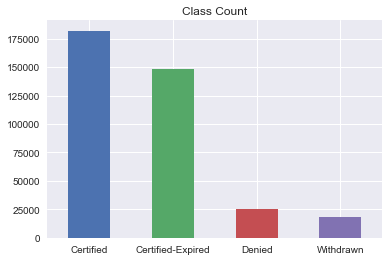

time: 415 ms


In [52]:
number_data.plot(kind='bar', title='Class Count', rot=0);

In [53]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

time: 4.12 ms


In [54]:
X=df3.drop(['case_status'], axis=1)
y=df3.case_status

time: 30.2 s


In [55]:
Counter(df3.case_status)

Counter({'Certified': 181933,
         'Denied': 25649,
         'Certified-Expired': 148586,
         'Withdrawn': 18194})

time: 86.7 ms


# Undersample

In [56]:
rus = RandomUnderSampler()
X_under, y_under = rus.fit_sample(X,y)

time: 1min 33s


In [57]:
Counter(y_under)

Counter({'Certified': 18194,
         'Certified-Expired': 18194,
         'Denied': 18194,
         'Withdrawn': 18194})

time: 8.4 ms


In [ ]:
# df_under=X_under.join(y_under)
#df_under.isnull().sum()

In [ ]:
# clf_rus = SVC().fit(X_under, y_under)
# cm = print_confusion_matrix(confusion_matrix(y, clf_rus.predict(X)), ['Certified', 'Certified-Expired', 'Denied', 'Withdrawn'])

## ADASYN

In [ ]:
# X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X,y)

In [ ]:
# Counter(y_adasyn)

In [ ]:
# clf_adasyn = SVC().fit(X_adasyn, y_adasyn)
# plot_decision_regions(X_adasyn, y_adasyn, clf_adasyn)
# plt.title(f'ADASYN SVC with y = {Counter(y_resampled)}')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.gcf().set_size_inches(12,8)

In [ ]:
# cm = print_confusion_matrix(confusion_matrix(y, clf_adasyn.predict(X)), ['Class 0', 'Class 1'])

In [ ]:
# sns.pairplot(df3, hue='case_status')

# Store as CSV

In [ ]:
# with open('clean_data1.pkl', 'wb') as picklefile:
#              pickle.dump(df_under, picklefile)

In [ ]:
# with open("clean_data1.pkl", 'rb') as picklefile: 
#       df = pickle.load(picklefile)
# df.to_csv('clean_data1.csv')
# df.head()

# Make Two Models and Pray this Works

In [ ]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)